In [189]:
import numpy as np
import matplotlib.pyplot as plt


In [190]:
def initialize_centroids(data, k):
    """
    Initializes the centroids by randomly selecting k points from the data.

    :param data: A 2D numpy array where each row is a data point
    :param k: Number of clusters
    :return: A 2D numpy array of k centroids
    """
    n_samples, n_features = data.shape
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    return centroids


In [191]:
def closest_centroid(data, centroids):
    """
    Finds the index of the closest centroid for each data point.

    :param data: A 2D numpy array where each row is a data point
    :param centroids: A 2D numpy array of current centroids
    :return: A 1D numpy array where each element is the index of the closest centroid for the corresponding data point
    """
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)


In [192]:
def compute_centroids(data, labels, k):
    """
    Computes the new centroids as the mean of the data points assigned to each cluster.

    :param data: A 2D numpy array where each row is a data point
    :param labels: A 1D numpy array of cluster indices corresponding to the closest centroids
    :param k: Number of clusters
    :return: A 2D numpy array of the new centroids
    """
    n_features = data.shape[1]
    centroids = np.zeros((k, n_features))
    
    for i in range(k):
        points_in_cluster = data[labels == i]
        if points_in_cluster.size:
            centroids[i] = points_in_cluster.mean(axis=0)
    
    return centroids


In [193]:
def k_means(data, k, max_iters=100, tol=1e-4):
    """
    Performs K-Means clustering on the input data.

    :param data: A 2D numpy array where each row is a data point
    :param k: Number of clusters
    :param max_iters: Maximum number of iterations to run the algorithm
    :param tol: Tolerance for convergence, i.e., if the centroids do not move much, the algorithm will stop
    :return: A tuple of (centroids, labels) where centroids is a 2D numpy array of final centroids and
             labels is a 1D numpy array of cluster indices for each data point
    """
    # Step 1: Initialize the centroids
    centroids = initialize_centroids(data, k)

    for _ in range(max_iters):
        # Step 2: Assign each data point to the closest centroid
        labels = closest_centroid(data, centroids)

        # Step 3: Calculate new centroids as the mean of the points in each cluster
        new_centroids = compute_centroids(data, labels, k)

        # Step 4: Check for convergence (if centroids do not change much)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels


In [194]:
def generate_data():
    nPerClust_SA = 100
    C1 = [1,1]
    C2 = [5,1]
    C3 = [3,-2]
    C4 = [4,4]
    blur = 1
    radius = np.array([0.8,0.8,0.8,0.8])
    
    C1Data = np.array([C1[0]+radius[0]*np.random.randn(nPerClust_SA)*blur , C1[1]+radius[0]*np.random.randn(nPerClust_SA)*blur ])
    C2Data = np.array([C2[0]+radius[1]*np.random.randn(nPerClust_SA)*blur , C2[1]+radius[1]*np.random.randn(nPerClust_SA)*blur ])
    C3Data = np.array([C3[0]+radius[2]*np.random.randn(nPerClust_SA)*blur , C3[1]+radius[2]*np.random.randn(nPerClust_SA)*blur ])
    C4Data = np.array([C4[0]+radius[3]*np.random.randn(nPerClust_SA)*blur , C4[1]+radius[3]*np.random.randn(nPerClust_SA)*blur ])

    np_data = np.hstack((C1Data,C2Data,C3Data,C4Data)).T

    Label1 = np.zeros((np.max(C1Data.shape),1))
    Label2 = Label1 + 1
    Label3 = Label1 + 2
    Label4 = Label1 + 3
    np_labels = np.vstack((Label1,Label2,Label3,Label4))
    
    return np_labels, np_data

In [195]:
# Plot the clusters
def plot_clusters(np_data, labels, k, centroids):
    colors = ['ro', 'go', 'bo', 'mo', 'co', 'yo', 'ko']  # Colors for different clusters

    for i in range(k):
        cluster_data = np_data[labels == i]
        plt.plot(cluster_data[:, 0], cluster_data[:, 1], colors[i % len(colors)], label=f"Cluster {i+1}")
        plt.plot(centroids[i][0],centroids[i][1], 'ko', label=f"Cluster {i+1}")

    plt.legend()
    plt.title(f"Clusters for k={k}")
    plt.show()

In [196]:
def cluster_and_plot(np_data):
    for k in [2, 3, 4]:  # Perform clustering for k=2, 3, and 4
        centroids, labels = k_means(np_data, k)
        plot_clusters(np_data, labels, k, centroids)


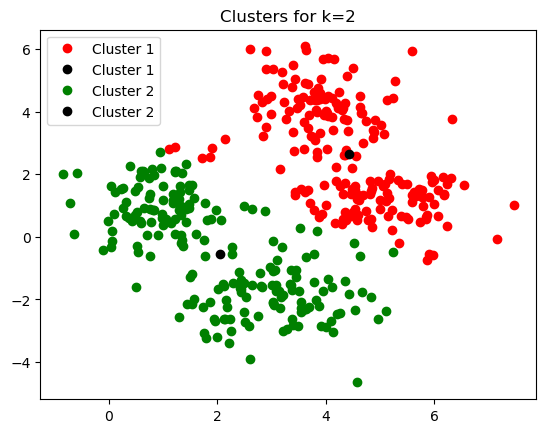

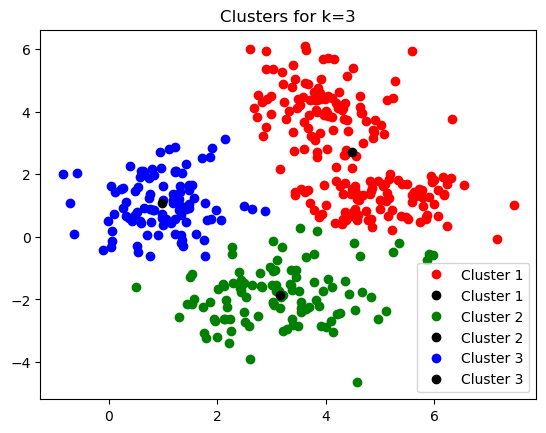

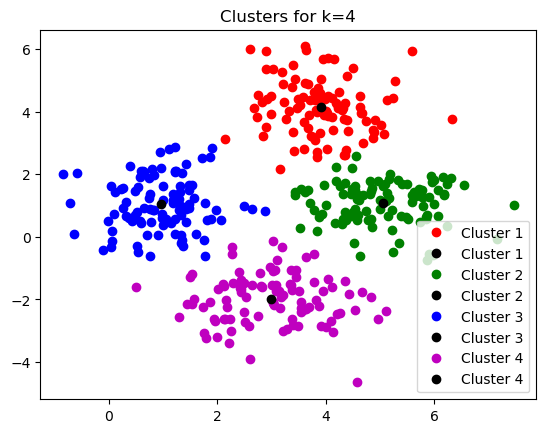

In [197]:
# Main script
labels, np_data = generate_data()  # Generate the data

# Cluster and plot for 2, 3, and 4 clusters
cluster_and_plot(np_data)

In [198]:
# Function to calculate error for each category
def category_error(data, labels, centroids):
    """
    Calculates the mean distance of points in each category to their centroid.
    :param data: 2D numpy array where each row is a data point
    :param labels: 1D numpy array of cluster indices for each data point
    :param centroids: 2D numpy array of centroid positions
    :return: Mean distance (error) for each category
    """
    error_per_category = []
    for i in range(centroids.shape[0]):  # for each centroid
        points_in_cluster = data[labels == i]
        if points_in_cluster.size > 0:
            distance = np.linalg.norm(points_in_cluster - centroids[i], axis=1)
            mean_distance = np.mean(distance**2)
            error_per_category.append(mean_distance)
    return np.array(error_per_category)

In [199]:

# Function to calculate total K-Means error
def total_error(data, labels, centroids):
    """
    Calculate the total error of the K-Means algorithm (sum of mean distances across all categories).
    :param data: 2D numpy array where each row is a data point
    :param labels: 1D numpy array of cluster indices for each data point
    :param centroids: 2D numpy array of centroid positions
    :return: Total errortotal_error
    """
    category_errors = category_error(data, labels, centroids)
    total = np.sum(category_errors)
    return total


In [200]:
# Function to plot the error vs number of clusters
def plot_error_vs_clusters(k_values, errors):
    """
    Plot the error of K-Means vs number of clusters.
    :param k_values: List of k values (number of clusters)
    :param errors: List of errors corresponding to each k
    """
    plt.plot(k_values, errors, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Total Error')
    plt.title('K-Means Error vs Number of Clusters')
    plt.grid(True)
    plt.show()

## Plots

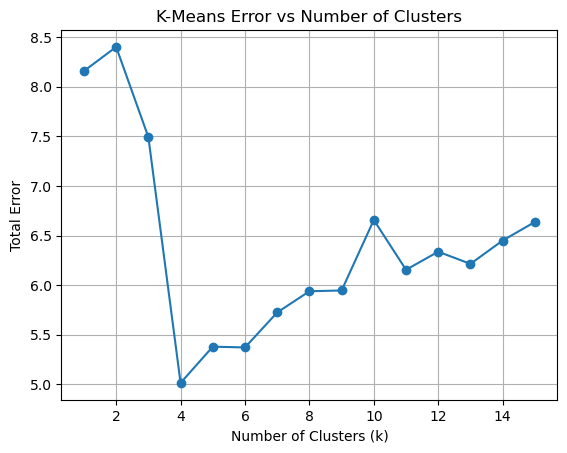

In [201]:
# Evaluate K-Means for k = 1 to 15 and calculate errors
k_values = range(1, 16)
errors = []

for k in k_values:
    centroids, labels = k_means(np_data, k)
    error = total_error(np_data, labels, centroids)
    errors.append(error)

# Plot the error as a function of the number of clusters
plot_error_vs_clusters(k_values, errors)